# Coffee Market Research

This notebook is separated into two sections. The first will be the code needed to open up the dashboard. The second will be a forecasting model for the coffee prices. 

## 1. Dashboard

In [3]:
# Import Libaries
import pandas as pd
import numpy as np
import plotly.express as px
import sqlite3
import dash
from dash import Dash, html, dcc, dash_table
from dash.dependencies import Input, Output

Data Import

In [4]:
# Connect to database
con = sqlite3.connect('coffee.db')
cur = con.cursor()

# Read all table names. We find four tables: "market", "price", "SND", and "coffee_type"
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# print(table_list)

# Read table into dataframe, save tables as df for future use
market_df = pd.read_sql_query("SELECT * FROM market", con)
price_df = pd.read_sql_query("SELECT * FROM price", con)
SND_df = pd.read_sql_query("SELECT * FROM SND", con)
coffee_type_df = pd.read_sql_query("SELECT * FROM coffee_type", con)

# Merge the dataframes for ease of analysis. Can do this b/c small dataset, but not recommended for large datasets

df = SND_df.merge(coffee_type_df, on = ['coffee_type_id'])
df = df.merge(market_df, on = ['date'])
df = df.merge(price_df, on = ['date', 'coffee_type_id'])

DatabaseError: Execution failed on sql 'SELECT * FROM market': no such table: market

Dashboard

In [ ]:
# Dash Visualization - Run all code and go to the provided link to see the visualization

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1(children='Select Coffee Type'),
    dcc.Dropdown(id="select_coffee_type",
                 options=[
                     {"label": "Arabica", "value": 'Arabica'},
                     {"label": "Robusta", "value": 'Robusta'}],
                 multi=False,
                 value='Arabica',
                 style={'width': "40%"}
                 ),

    html.H1(children='Interactive Graph'),
    html.H3(children='Select Metric(s)'),
    dcc.Checklist(id="select_metric",
                options=[
                    {"label": "Price", "value": 'price'},
                    {"label": "Supply", "value": 'total_supply'},
                    {"label": "Demand", "value": 'total_demand'},
                    {"label": "Consumption", "value": 'total_consumption'},
                    {"label": "Stock", "value": 'total_stock'},
                    {"label": "Certified Stock", "value": 'certified_stock'}],
                style={'width': "40%"}
                ),

    html.H3(children='Output: Metrics Over Time'),
    dcc.Graph(id="supply_demand_graph", figure = {}),
    
    html.H1(children='Key Metrics'),

    html.H3(children='Select Year'),
    dcc.Slider(2002, 2023, 1,
               value = 2023,
               marks=None,
               tooltip={"placement": "bottom", "always_visible": True},
               id = "selected_year"),

    html.H3(children='Output: Market Evolution of Selected Coffee Type to Previous Year'),
    dash_table.DataTable(
            id="output_df",
            style_as_list_view=True,
        ),
])

@app.callback(
    [Output(component_id='supply_demand_graph', component_property='figure'),
     Output(component_id='output_df', component_property='data'),
     Output(component_id='output_df', component_property='columns')],
    [Input(component_id='select_coffee_type', component_property='value'),
    Input(component_id='select_metric', component_property='value'),
    Input(component_id='selected_year', component_property='value')]
)
def update_graph(coffee_type, metric, year):
    container = metric
    year = str(year)

    # Clone df to dff
    dff = df.copy()
    dff = dff[dff["coffee_type"] == coffee_type]

    # For highlighting area of projections
    projs = dff[dff['actvsproj_x'] == 'proj']['date']

    # Main figure
    fig = px.line(dff, x = 'date', y = metric)
    fig.add_vrect(
    x0=min(projs), x1=max(projs),
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
    ),

    # Table
    # New df
    df_year = dff.copy()
    df_year['date'] = pd.to_datetime(df_year.date)
    df_year = df_year.groupby([df_year.date.dt.to_period('Y'), df_year.coffee_type_id]).mean('total_demand').reset_index()
    df_year['date'] = df_year['date'].astype(str)
    df_year = df_year[df_year['date'].isin([str(int(year) - 1), year])]
    # metrics df, gives percent change of year over year
    # get year data in a list
    names = df_year.columns.tolist()[2:]
    prev_year_data = df_year.iloc[0].tolist()[2:]
    year_data = df_year.iloc[1].tolist()[2:]
    # percent change
    pctch = np.divide(np.subtract(year_data, prev_year_data), prev_year_data) * 100
    # create new df
    df_changes = pd.DataFrame({'Metric': names, str(int(year) - 1): prev_year_data, year: year_data, "% Change": pctch})
    df_changes = df_changes.round(2)
    df_changes['% Change'] = df_changes['% Change'].astype(str) + '%'
    

    data=df_changes.to_dict('records')
    columns=[{"name": i, "id": i} for i in df_changes.columns]

    return fig, data, columns

app.run()

## 2. Forecasting

This section only contains the final forecasting model and its metrics. For how we led up to the model, refer to analysis-forecast-draft.ipynb. 

In [194]:
# Import libraries + Function for forecast
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore") # For library depreciation warnings

def multilinreg(coffee_type):
    # Grab a coffee of dataframe, filter for coffee type
    df_copy = df.copy()
    df_copy = df_copy[df_copy['coffee_type_id'] == coffee_type]
    # DO NOT  include projections while training
    df_copy = df_copy[df_copy['actvsproj_x'] == 'act']

    # Clean up date column for analysis
    df_copy['date'] = pd.to_datetime(df_copy['date'])
    df_copy['date'] = (df_copy['date'] - df_copy['date'].min()).dt.days

    # Split data into X and y
    X = df_copy[['date', 'total_supply', 'total_demand', 'total_consumption', 'total_stock', 'certified_stock']]  # Add all your feature columns
    y = df_copy['price']
    X['total_supply'] = X['total_supply'].apply(np.log)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    # Calculate the residuals
    residuals = y_test - y_pred

    # Create a residual plot
    plt.scatter(y_pred, residuals, color='green')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.title('Residual Plot (Multiple Linear Regression)')
    plt.show()

    # Add a constant term (intercept) to the independent variables
    X = sm.add_constant(X)

    # Fit the multiple linear regression model
    model_res = sm.OLS(y, X).fit()

    # Display the summary statistics
    print(model_res.summary())

    # Final forecast
    df_test = df.copy()
    df_test = df_test[df_test['coffee_type_id'] == coffee_type]

    # Include projections
    df_test = df_test[df_test['actvsproj_x'] == 'proj']

    df_test['date'] = pd.to_datetime(df_test['date'])
    df_test['date'] = (df_test['date'] - df_test['date'].min()).dt.days

    X_new = df_test[['date', 'total_supply', 'total_demand', 'total_consumption', 'total_stock', 'certified_stock']]  # Add all your feature columns
    X_new['total_supply'] = X_new['total_supply'].apply(np.log) # Remember to log transform supply. Explained in draft notebook. 

    predictions = model.predict(X_new)

    # Line graph of forecasted prices
    orig_df = df.copy()
    orig_df = orig_df[orig_df['coffee_type_id'] == coffee_type]
    orig_df.loc[orig_df.actvsproj_x == 'proj', 'price'] = predictions

    fig = px.line(orig_df, x = 'date', y = 'price', title = 'Forecasted Prices')
    projs = orig_df[orig_df['actvsproj_x'] == 'proj']['date']
    fig.add_vrect(
        x0=min(projs), x1=max(projs),
        fillcolor="LightSalmon", opacity=0.5,
        layer="below", line_width=0,
        )

    fig.show()

### Forecast for Arabica Coffee

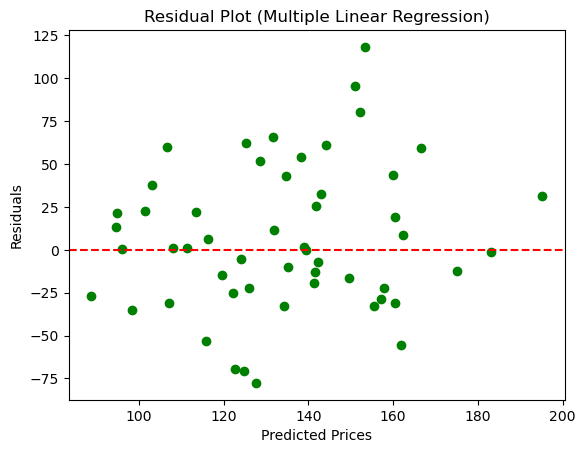

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     27.07
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           6.35e-25
Time:                        04:54:16   Log-Likelihood:                -1331.9
No. Observations:                 263   AIC:                             2678.
Df Residuals:                     256   BIC:                             2703.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -838.5247    289.72

In [195]:
# Run function for Arabica Coffee
multilinreg(1)

### Forecast for Robusta Coffee

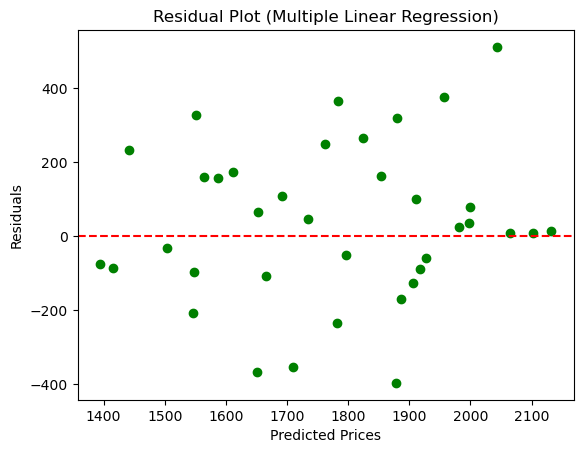

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     24.41
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           5.71e-21
Time:                        04:54:51   Log-Likelihood:                -1277.2
No. Observations:                 184   AIC:                             2568.
Df Residuals:                     177   BIC:                             2591.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4921.1856    622.76

In [196]:
# Run function for Robusta Coffee
multilinreg(2)